In [ ]:
!pip install wavencoder

# install torchaudio for audio dataset
!pip install torchaudio


     |████████████████████████████████| 1.9MB 10.9MB/s 
     |████████████████████████████████| 1.7MB 36.9MB/s 
     |████████████████████████████████| 133kB 35.1MB/s 
     |████████████████████████████████| 61kB 8.0MB/s 
     |████████████████████████████████| 112kB 39.9MB/s 
     |████████████████████████████████| 645kB 34.7MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-cp37-none-any.whl size=141231 sha256=cb044d63523b24a342ce32dcb5277d461de933d2e353ce2aaf363d425e15c7b4
  Stored in directory: /root/.cache/pip/wheels/e3/e2/fa/b78480b448b8579ddf393bebd3f47ee23aa84c89b6a78285c8
Successfully built antlr4-python3-runtime
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
# import wavencoder models and trainer
from wavencoder.models import Wav2Vec, LSTM_Attn_Classifier
from wavencoder.trainer import train, test_evaluate_classifier, test_predict_classifier

# import torch modules and torchaudio for data
import torchaudio
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, Dataset

import random
import IPython
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/My\ Drive/ASR_Project_Shared

/content/gdrive/.shortcut-targets-by-id/1dovc8A9Q0Yu-3j97BcX_N4CGIbnUfGMF/ASR_Project_Shared


In [ ]:
import os

ROOT_PATH='./drive/MyDrive/ASR_Project_Shared/'
relative_path = 'final_metadata/denoised/'

train_file = './final_metadata/normal/train_metadata_speech{all_clap}_noise{all_clap+noiseclips}.csv'


test_file_1 = './final_metadata/normal/test_metadata_speech{all_clap}_noise{qut+spam} - test_metadata_speech{all_clap}_noise{qut+spam}.csv'

test_file_2 = './final_metadata/normal/test_metadata_speech{all_clap}_noise{all_clap+noiseclips+spam} - test_metadata_speech{all_clap}_noise{all_clap+noiseclips+spam}.csv'


In [ ]:
import pandas as pd
train_df = pd.read_csv(train_file)

train_df.head()

,file_path,label
0,./final_data/noiseBINgte2/Hindi_clipsBINgte2/2...,0
1,./final_data/all_clap_speech/Marathi/128308_1.wav,1
2,./final_data/all_clap_speech/Tamil/228021_2.wav,1
3,./final_data/all_clap_speech/Hindi/26411_1.wav,1
4,./final_data/all_clap_speech/Hindi/24425_2.wav,1


In [ ]:
file_names = list(train_df['file_path'])

In [ ]:
wave=[]
for i in file_names:
  waveform, sample_rate = torchaudio.load(i)
  wave.append(waveform)

print(wave)

[tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.2207e-04,
         -1.2207e-04, -9.1553e-05]]), tensor([[0.0026, 0.0039, 0.0038,  ..., 0.0313, 0.0329, 0.0329]]), tensor([[ 0.0103,  0.0120,  0.0066,  ..., -0.0178, -0.0235, -0.0228]]), tensor([[ 0.0001, -0.0016, -0.0015,  ...,  0.0273,  0.0311,  0.0316]]), tensor([[-0.0005, -0.0006, -0.0006,  ...,  0.0009,  0.0009,  0.0008]]), tensor([[ 0.0158,  0.0217,  0.0204,  ..., -0.0015, -0.0009,  0.0003]]), tensor([[-0.0191, -0.0220, -0.0179,  ..., -0.0141, -0.0141, -0.0144]]), tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0076,  0.0059, -0.0008]]), tensor([[-0.0016, -0.0046, -0.0091,  ...,  0.0061,  0.0042, -0.0017]]), tensor([[-0.0147, -0.0387, -0.0674,  ...,  0.0625,  0.1000,  0.0711]]), tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0095, 0.0108, 0.0096]]), tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 6.1035e-05,
         9.1553e-05]]), tensor([[ 9.1553e-05,  6.1035e-05,  4.9438e-03,  ..., -1.2817e-03,
         -1.2207e-03

In [ ]:
train_df['waveform'] = wave

In [ ]:
test_df = pd.read_csv(test_file_1)
file_names1 = list(test_df['file_path'])

test_df1 = pd.read_csv(test_file_2)
file_names2 = list(test_df1['file_path'])

In [ ]:
wave1=[]
for i in file_names1:
  waveform, sample_rate = torchaudio.load(i)
  wave1.append(waveform)

test_df['waveform'] = wave1

wave1=[]
for i in file_names2:
  waveform, sample_rate = torchaudio.load(i)
  wave1.append(waveform)

test_df1['waveform'] = wave1

In [ ]:
data_train =[]
for i in range(0, len(train_df['waveform'])):
  x = train_df['waveform'][i]
  y = train_df['label'][i]
  data_train.append((x,y))

data_test =[]
for i in range(0, len(test_df['waveform'])):
  x = test_df['waveform'][i]
  y = test_df['label'][i]
  data_test.append((x,y))

In [ ]:
class SpeechDataset(Dataset):
    def __init__(self, dataset, transforms=None):
        self.dataset = dataset
        self.transforms = transforms
            
    def __len__(self):
        return len(self.dataset)    
    
    def pad_crop_wave(self, waveform, l):
        l_wave = waveform.shape[1]
        if l_wave > l:
            i=0
            waveform = waveform[:, i:i+l]
        elif l_wave < l:
            delta = l-l_wave
            if delta > l_wave:
                waveform = nn.ConstantPad1d((0, delta), 0)(waveform)
            else:
                waveform_new = torch.randn(waveform.shape[0], l)
                waveform_new[:, :l_wave] = waveform
                i=0
                waveform_new[:, l_wave:] = waveform[:, i:i+delta]
                waveform = waveform_new
        else:
            waveform = waveform
        return waveform

    def __getitem__(self,idx):
        waveform = self.dataset[idx][0]
        waveform = self.pad_crop_wave(waveform, l=16000)
        if self.transforms:
            waveform = self.transforms(waveform)
        label = self.dataset[idx][1]
        
        return waveform.squeeze(0), label

In [ ]:
audio_dataset = SpeechDataset(data_train)

In [ ]:
print(audio_dataset[0][0].shape)

torch.Size([16000])


In [ ]:
train_len = int(len(audio_dataset) * 0.8)
val_len = len(audio_dataset) - train_len

train_ds, val_ds = random_split(audio_dataset, [train_len, val_len])
len(train_ds), len(val_ds)

(3591, 898)

In [ ]:
trainloader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(val_ds, batch_size=32, shuffle=False)

In [ ]:
model = nn.Sequential(
    Wav2Vec(pretrained=True),
    LSTM_Attn_Classifier(512, 64, 2)
)
print(model)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-49-85503e8b2684>", line 2, in <module>
    Wav2Vec(pretrained=True),
  File "/usr/local/lib/python3.7/dist-packages/wavencoder/models/wav2vec.py", line 206, in __init__
    cp = torch.load(filename, map_location=self.device)
  File "/usr/local/lib/python3.7/dist-packages/torch/serialization.py", line 593, in load
    return _legacy_load(opened_file, map_location, pickle_module, **pickle_load_args)
  File "/usr/local/lib/python3.7/dist-packages/torch/serialization.py", line 747, in _legacy_load
    return legacy_load(f)
  File "/usr/local/lib/python3.7/dist-packages/torch/serialization.py", line 669, in legacy_load
    with closing(tarfile.open(fileobj=f, mode='r:', format=tarfile.PAX_FORMAT)) as tar, \
  File "/usr/lib/python3.7/tarfile.py", line 1593, in open
    return f

FileNotFoundError: ignored

In [ ]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=.0001, max_lr=.0001, step_size_up=10)

In [ ]:
model, train_dict = train(model, trainloader, valloader, n_epochs=3, optimizer=optimizer, scheduler=scheduler)




Train:   0%|          | 0/57 [00:00<?, ?it/s]

Train:   2%|▏         | 1/57 [00:17<16:36, 17.80s/it]

Train:   4%|▎         | 2/57 [00:34<16:02, 17.50s/it]

Train:   5%|▌         | 3/57 [00:50<15:24, 17.13s/it]

Train:   7%|▋         | 4/57 [01:07<14:52, 16.83s/it]

Train:   9%|▉         | 5/57 [01:23<14:27, 16.68s/it]

Train:  11%|█         | 6/57 [01:39<14:04, 16.55s/it]

Train:  12%|█▏        | 7/57 [01:56<13:46, 16.53s/it]

Train:  14%|█▍        | 8/57 [02:12<13:30, 16.54s/it]

Train:  16%|█▌        | 9/57 [02:29<13:14, 16.55s/it]

Train:  18%|█▊        | 10/57 [02:45<12:56, 16.52s/it]

Train:  19%|█▉        | 11/57 [03:02<12:41, 16.55s/it]

Train:  21%|██        | 12/57 [03:18<12:24, 16.54s/it]

Train:  23%|██▎       | 13/57 [03:35<12:06, 16.50s/it]

Train:  25%|██▍       | 14/57 [03:51<11:49, 16.50s/it]

Train:  26%|██▋       | 15/57 [04:08<11:35, 16.56s/it]

Train:  28%|██▊       | 16/57 [04:24<11:17, 16.53s/it]

Train:  30%|██▉       | 17/57 [04:41<10:58, 16.46s/it]

Train:  

Validation loss reduced from inf to 0.038795, saving model at trained_model.pt ...
Updating lr to [0.0001]
Epoch : 01
Train Loss = 0.2190	Train Acc = 0.9114583333333334
  Val Loss = 0.0388	  Val Acc = 0.9881465517241379





Train:   2%|▏         | 1/57 [00:16<15:17, 16.39s/it]

Train:   4%|▎         | 2/57 [00:32<14:58, 16.33s/it]

Train:   5%|▌         | 3/57 [00:48<14:39, 16.28s/it]

Train:   7%|▋         | 4/57 [01:04<14:21, 16.25s/it]

Train:   9%|▉         | 5/57 [01:21<14:05, 16.25s/it]

Train:  11%|█         | 6/57 [01:37<13:49, 16.27s/it]

Train:  12%|█▏        | 7/57 [01:53<13:31, 16.23s/it]

Train:  14%|█▍        | 8/57 [02:09<13:14, 16.21s/it]

Train:  16%|█▌        | 9/57 [02:26<13:02, 16.31s/it]

Train:  18%|█▊        | 10/57 [02:42<12:49, 16.38s/it]

Train:  19%|█▉        | 11/57 [02:59<12:34, 16.40s/it]

Train:  21%|██        | 12/57 [03:15<12:18, 16.40s/it]

Train:  23%|██▎       | 13/57 [03:32<12:01, 16.41s/it]

Train:  25%|██▍       | 14/57 [03:48<11:43, 16.37s/it]

Train:  26%|██▋       | 15/57 [04:04<11:25, 16.32s/it]

Train:  28%|██▊       | 16/57 [04:20<11:06, 16.26s/it]

Train:  30%|██▉       | 17/57 [04:36<10:48, 16.22s/it]

Train:  32%|███▏      | 18/57 [04:52<10:30, 16.16s/it]


Validation loss reduced from 0.038795 to 0.029233, saving model at trained_model.pt ...
Updating lr to [0.0001]
Epoch : 02
Train Loss = 0.0334	Train Acc = 0.9871162280701754
  Val Loss = 0.0292	  Val Acc = 0.9924568965517241





Train:   2%|▏         | 1/57 [00:16<15:17, 16.38s/it]

Train:   4%|▎         | 2/57 [00:32<14:55, 16.29s/it]

Train:   5%|▌         | 3/57 [00:48<14:39, 16.28s/it]

Train:   7%|▋         | 4/57 [01:05<14:24, 16.32s/it]

Train:   9%|▉         | 5/57 [01:21<14:09, 16.33s/it]

Train:  11%|█         | 6/57 [01:37<13:49, 16.27s/it]

Train:  12%|█▏        | 7/57 [01:53<13:31, 16.23s/it]

Train:  14%|█▍        | 8/57 [02:10<13:16, 16.26s/it]

Train:  16%|█▌        | 9/57 [02:26<13:01, 16.29s/it]

Train:  18%|█▊        | 10/57 [02:42<12:43, 16.25s/it]

Train:  19%|█▉        | 11/57 [02:58<12:27, 16.24s/it]

Train:  21%|██        | 12/57 [03:14<12:09, 16.22s/it]

Train:  23%|██▎       | 13/57 [03:31<11:55, 16.27s/it]

Train:  25%|██▍       | 14/57 [03:47<11:41, 16.32s/it]

Train:  26%|██▋       | 15/57 [04:04<11:26, 16.35s/it]

Train:  28%|██▊       | 16/57 [04:20<11:11, 16.37s/it]

Train:  30%|██▉       | 17/57 [04:36<10:53, 16.33s/it]

Train:  32%|███▏      | 18/57 [04:53<10:35, 16.29s/it]


Updating lr to [0.0001]
Epoch : 03
Train Loss = 0.0469	Train Acc = 0.9788925438596491
  Val Loss = 0.0298	  Val Acc = 0.9838362068965517



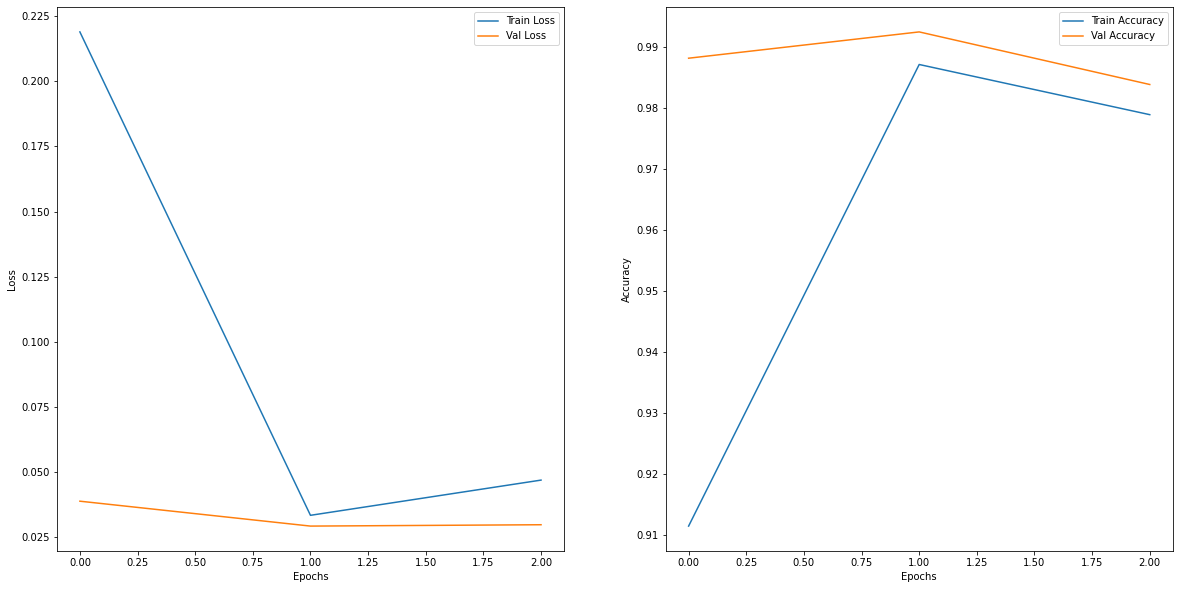

In [ ]:
train_losses = train_dict['train_losses']
train_accuracies = train_dict['train_accuracies']
val_losses = train_dict['val_losses']
val_accuracies = train_dict['val_Accuracies']

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

In [ ]:
t1 =[]

for i in data_test:
  x = torch.mean(i[0],0)
  x = x.unsqueeze(0)
  t1.append((x, i[1]))


In [ ]:
print(t1[10][0])

tensor([[-0.0838, -0.0695, -0.0605,  ...,  0.2924,  0.3037,  0.3149]])


In [ ]:
audio_test1 = SpeechDataset(t1)
testloader = torch.utils.data.DataLoader(audio_test1, batch_size=32, shuffle=False)
#audio_test1[0][0].shape
print(data_train[10][0].shape)
print(t1[10][0].shape)


torch.Size([1, 48000])
torch.Size([1, 33728])


In [ ]:
test_prediction_dict = test_predict_classifier(model, testloader)











  0%|          | 0/33 [00:00<?, ?it/s]









  3%|▎         | 1/33 [00:02<01:21,  2.56s/it]









  6%|▌         | 2/33 [00:05<01:19,  2.57s/it]









  9%|▉         | 3/33 [00:07<01:16,  2.56s/it]









 12%|█▏        | 4/33 [00:10<01:14,  2.56s/it]









 15%|█▌        | 5/33 [00:12<01:11,  2.57s/it]









 18%|█▊        | 6/33 [00:15<01:09,  2.57s/it]









 21%|██        | 7/33 [00:17<01:06,  2.57s/it]









 24%|██▍       | 8/33 [00:20<01:04,  2.57s/it]









 27%|██▋       | 9/33 [00:23<01:02,  2.59s/it]









 30%|███       | 10/33 [00:25<01:00,  2.61s/it]









 33%|███▎      | 11/33 [00:28<00:57,  2.61s/it]









 36%|███▋      | 12/33 [00:31<00:54,  2.61s/it]









 39%|███▉      | 13/33 [00:33<00:51,  2.60s/it]









 42%|████▏     | 14/33 [00:36<00:49,  2.58s/it]









 45%|████▌     | 15/33 [00:38<00:46,  2.57s/it]









 48%|████▊     | 16/33 [00:41<00:43,  2.58s/it]









 52%|█████▏    | 17/33 [00:43<00:41,  2

In [ ]:
true_pred=[]
for i in data_test:
  true_pred.append(i[1])

print(true_pred)

[1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, labels):
    """
    plots the confusion matrix
    """
    matrix = confusion_matrix(y_true, y_pred)    
    fig, ax = plt.subplots(figsize=(4,3))
    plt.imshow(matrix)
    ax.set_xticks(range(len(labels)));
    ax.set_xticklabels(labels, rotation=0)
    ax.set_yticks(range(len(labels)));
    ax.set_yticklabels(labels)
    max_confusions = 0
    confused_classes = (-1, -1)
    for i, true_label in enumerate(matrix):
        for j, predicted_label in enumerate(true_label):
            text = ax.text(j, i, matrix[i, j],
                        ha="center", va="center", color="r");
    plt.tick_params(axis=u'both', which=u'both',length=0)
    plt.title("Confusion Matrix");

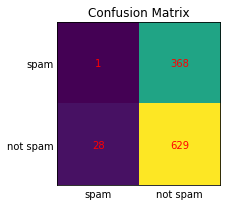

In [ ]:
labels =['spam','not spam']

plot_confusion_matrix(true_pred, test_prediction_dict["test_predictions"], labels)

In [ ]:
test_evaluate_classifier(model, testloader)











  0%|          | 0/33 [00:00<?, ?it/s]









  3%|▎         | 1/33 [00:02<01:23,  2.62s/it]









  6%|▌         | 2/33 [00:05<01:21,  2.62s/it]









  9%|▉         | 3/33 [00:07<01:18,  2.61s/it]









 12%|█▏        | 4/33 [00:10<01:15,  2.59s/it]









 15%|█▌        | 5/33 [00:13<01:14,  2.65s/it]









 18%|█▊        | 6/33 [00:15<01:11,  2.64s/it]









 21%|██        | 7/33 [00:18<01:09,  2.66s/it]









 24%|██▍       | 8/33 [00:21<01:06,  2.65s/it]









 27%|██▋       | 9/33 [00:23<01:02,  2.62s/it]









 30%|███       | 10/33 [00:26<00:59,  2.60s/it]









 33%|███▎      | 11/33 [00:28<00:56,  2.58s/it]









 36%|███▋      | 12/33 [00:31<00:54,  2.58s/it]









 39%|███▉      | 13/33 [00:33<00:51,  2.59s/it]









 42%|████▏     | 14/33 [00:36<00:49,  2.59s/it]









 45%|████▌     | 15/33 [00:39<00:46,  2.59s/it]









 48%|████▊     | 16/33 [00:41<00:44,  2.60s/it]









 52%|█████▏    | 17/33 [00:44<00:41,  2

{'test_acc': 0.625, 'test_loss': 1.8939601133408195}

In [ ]:
data_test1 =[]
for i in range(0, len(test_df1['waveform'])):
  x = test_df1['waveform'][i]
  y = test_df1['label'][i]
  data_test1.append((x,y))

In [ ]:
t1 =[]

for i in data_test1:
  x = torch.mean(i[0],0)
  x = x.unsqueeze(0)
  t1.append((x, i[1]))


In [ ]:
audio_test1 = SpeechDataset(t1)
testloader = torch.utils.data.DataLoader(audio_test1, batch_size=32, shuffle=False)
#audio_test1[0][0].shape
print(data_train[10][0].shape)
print(t1[10][0].shape)


torch.Size([1, 48000])
torch.Size([1, 48000])


In [ ]:
test_prediction_dict = test_predict_classifier(model, testloader)











  0%|          | 0/47 [00:00<?, ?it/s]









  2%|▏         | 1/47 [00:02<01:58,  2.58s/it]









  4%|▍         | 2/47 [00:05<01:55,  2.57s/it]









  6%|▋         | 3/47 [00:07<01:52,  2.56s/it]









  9%|▊         | 4/47 [00:10<01:50,  2.56s/it]









 11%|█         | 5/47 [00:12<01:46,  2.54s/it]









 13%|█▎        | 6/47 [00:15<01:44,  2.54s/it]









 15%|█▍        | 7/47 [00:17<01:41,  2.53s/it]









 17%|█▋        | 8/47 [00:20<01:39,  2.55s/it]









 19%|█▉        | 9/47 [00:22<01:37,  2.55s/it]









 21%|██▏       | 10/47 [00:25<01:34,  2.55s/it]









 23%|██▎       | 11/47 [00:28<01:31,  2.55s/it]









 26%|██▌       | 12/47 [00:30<01:28,  2.54s/it]









 28%|██▊       | 13/47 [00:33<01:26,  2.54s/it]









 30%|██▉       | 14/47 [00:35<01:23,  2.54s/it]









 32%|███▏      | 15/47 [00:38<01:21,  2.54s/it]









 34%|███▍      | 16/47 [00:40<01:18,  2.54s/it]









 36%|███▌      | 17/47 [00:43<01:15,  2

In [ ]:
true_pred=[]
for i in data_test1:
  true_pred.append(i[1])

print(true_pred)

test_evaluate_classifier(model, testloader)











  0%|          | 0/47 [00:00<?, ?it/s]

[0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 











  2%|▏         | 1/47 [00:02<01:57,  2.55s/it]









  4%|▍         | 2/47 [00:05<01:55,  2.57s/it]









  6%|▋         | 3/47 [00:07<01:52,  2.56s/it]









  9%|▊         | 4/47 [00:10<01:50,  2.56s/it]









 11%|█         | 5/47 [00:12<01:47,  2.57s/it]









 13%|█▎        | 6/47 [00:15<01:45,  2.58s/it]









 15%|█▍        | 7/47 [00:18<01:43,  2.58s/it]









 17%|█▋        | 8/47 [00:20<01:39,  2.56s/it]









 19%|█▉        | 9/47 [00:23<01:37,  2.56s/it]









 21%|██▏       | 10/47 [00:25<01:34,  2.55s/it]









 23%|██▎       | 11/47 [00:28<01:31,  2.55s/it]









 26%|██▌       | 12/47 [00:30<01:29,  2.55s/it]









 28%|██▊       | 13/47 [00:33<01:26,  2.55s/it]









 30%|██▉       | 14/47 [00:36<01:26,  2.61s/it]









 32%|███▏      | 15/47 [00:38<01:24,  2.63s/it]









 34%|███▍      | 16/47 [00:41<01:21,  2.63s/it]









 36%|███▌      | 17/47 [00:43<01:18,  2.61s/it]









 38%|███▊      | 18/47 [00:46<

{'test_acc': 0.7332446808510638, 'test_loss': 1.3722108082568392}

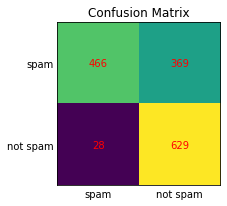

In [ ]:
plot_confusion_matrix(true_pred, test_prediction_dict["test_predictions"], labels)